In [1]:
!pip install pennylane

In [2]:
import pandas as pd
import glob
import os

DATA_DIR = "CICDS"  # folder containing many files

# Collect all files
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
parquet_files = glob.glob(os.path.join(DATA_DIR, "*.parquet"))

dfs = []

# Load CSVs
for file in csv_files:
    print(f"Loading {os.path.basename(file)}")
    dfs.append(pd.read_csv(file))

# Load Parquet files
for file in parquet_files:
    print(f"Loading {os.path.basename(file)}")
    dfs.append(pd.read_parquet(file))

# Concatenate all
df_full = pd.concat(dfs, ignore_index=True)

print(f"\nLoaded {df_full.shape[0]:,} rows × {df_full.shape[1]} columns")
print(df_full.head())

print("\nClass breakdown (combined):")
print(df_full[' Label'].value_counts())



Loading Friday-WorkingHours-Morning.pcap_ISCX.csv
Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loading Tuesday-WorkingHours.pcap_ISCX.csv
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loading Wednesday-workingHours.pcap_ISCX.csv
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Loaded 2,300,825 rows × 79 columns
    Destination Port   Flow Duration   Total Fwd Packets  \
0               3268       112740690                  32   
1                389       112740560                  32   
2                  0       113757377                 545   
3               5355          100126                  22   
4                  0           54760                   4   

    Total Backward Packets  Total Length of Fwd Packets  \
0                       16                         6448   
1                       16                         6448   
2                        0             

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All imports loaded")


✅ All imports loaded


In [5]:
# ============================================================
# ENHANCED PREPROCESSING WITH PCA & FEATURE SELECTION
# ============================================================

LABEL_COL = ' Label'  # Adjust for your dataset
N_QUBITS = 8  # Target number of qubits

print("="*80)
print("DATA PREPROCESSING WITH PCA")
print("="*80)

# Load and check labels
print("\nLabel distribution:")
print(df_full[LABEL_COL].value_counts())

y_full = df_full[LABEL_COL].values
unique_labels = np.unique(y_full)

# Binary encoding
if len(unique_labels) > 2:
    print(f"\n⚠️  Multiple classes detected: {unique_labels}")
    print("Converting to binary (first class=0, rest=1)")
    y_full = (y_full != unique_labels[0]).astype(int)
else:
    y_full = y_full.astype(int)

print(f"Binary distribution: {np.bincount(y_full)}")

# Extract numeric features
feature_cols = [c for c in df_full.columns 
                if c != LABEL_COL and pd.api.types.is_numeric_dtype(df_full[c])]
X_full = df_full[feature_cols].values

print(f"\n📊 Original features: {X_full.shape[1]}")

# Clean data
X_full = np.nan_to_num(X_full, posinf=0.0, neginf=0.0, nan=0.0)

# Sample 50K
TOTAL_SAMPLES = 50000
if len(X_full) > TOTAL_SAMPLES:
    indices = np.random.choice(len(X_full), TOTAL_SAMPLES, replace=False)
    X_full = X_full[indices]
    y_full = y_full[indices]

print(f"Using {len(X_full):,} samples")

# ============================================================
# OPTION 1: PCA to exactly N_QUBITS dimensions
# ============================================================
print(f"\n🔬 Applying PCA to reduce to {N_QUBITS} dimensions...")

scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_full)

pca = PCA(n_components=N_QUBITS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"✅ PCA complete: {N_QUBITS} components")
print(f"   Explained variance: {cumulative_var[-1]*100:.2f}%")
print(f"   Per component: {explained_var}")

# ============================================================
# OPTION 2: Feature Selection + PCA (Hybrid approach)
# ============================================================
print(f"\n🎯 Alternative: SelectKBest + PCA...")

# First select top 20 features via mutual information
selector = SelectKBest(mutual_info_classif, k=min(20, X_full.shape[1]))
X_selected = selector.fit_transform(X_scaled, y_full)

print(f"   Selected {X_selected.shape[1]} features via mutual info")

# Then PCA to N_QUBITS
pca_hybrid = PCA(n_components=N_QUBITS, random_state=RANDOM_STATE)
X_hybrid = pca_hybrid.fit_transform(X_selected)

explained_var_hybrid = pca_hybrid.explained_variance_ratio_
cumulative_var_hybrid = np.cumsum(explained_var_hybrid)

print(f"✅ Hybrid PCA: {cumulative_var_hybrid[-1]*100:.2f}% variance retained")

# ============================================================
# CHOOSE STRATEGY (edit this line to switch)
# ============================================================
STRATEGY = "PCA"  # Options: "PCA" or "HYBRID"

if STRATEGY == "PCA":
    X_reduced = X_pca
    print(f"\n✅ Using pure PCA approach")
else:
    X_reduced = X_hybrid
    print(f"\n✅ Using SelectKBest + PCA hybrid")

print(f"Final feature shape: {X_reduced.shape}")

# ============================================================
# CREATE 5 SUBSETS
# ============================================================
SUBSET_SIZE = 10000
N_SUBSETS = 5

subsets = []
for i in range(N_SUBSETS):
    start_idx = i * SUBSET_SIZE
    end_idx = (i + 1) * SUBSET_SIZE
    
    X_subset = X_reduced[start_idx:end_idx]
    y_subset = y_full[start_idx:end_idx]
    
    # 70-30 split
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, test_size=0.3,
        random_state=RANDOM_STATE, stratify=y_subset
    )
    
    subsets.append({
        'subset_id': i + 1,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    })
    
    print(f"\nSubset {i+1}: Train={X_train.shape}, Test={X_test.shape}")
    print(f"  Class balance: {np.bincount(y_train)}")

print(f"\n✅ {N_SUBSETS} subsets created with {N_QUBITS}-dimensional features")


DATA PREPROCESSING WITH PCA

Label distribution:
 Label
BENIGN                        1743179
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

⚠️  Multiple classes detected: ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack � Brute Force' 'Web Attack � Sql Injection'
 'Web Attack � XSS']
Converting to binary (first class=0, rest=1)
Binary distribution: [1743179  557646]



In [6]:
N_QUBITS = 8
dev = qml.device("default.qubit", wires=N_QUBITS)
dev_train = qml.device("default.qubit", wires=N_QUBITS)

def ring_pairs(n):
    return [(i, (i+1) % n) for i in range(n)]

@qml.qnode(dev)
def zz_fixed_enhanced(x):
    pairs = ring_pairs(N_QUBITS)
    
    for _ in range(2):
        for i in range(N_QUBITS):
            qml.Hadamard(wires=i)
            qml.RZ(x[i], wires=i)
            qml.RY(x[i], wires=i)
        
        for i, j in pairs:
            qml.CNOT(wires=[i, j])
            qml.RZ(x[i] * x[j], wires=j)
            qml.CNOT(wires=[i, j])
    
    obs = [qml.expval(qml.PauliZ(w)) for w in range(N_QUBITS)]
    obs += [qml.expval(qml.prod(qml.PauliZ(i), qml.PauliZ(j))) for i, j in pairs]
    return obs

def trainable_zz_enhanced(x, params, wires, reps=2):
    pairs = ring_pairs(len(wires))
    idx = 0
    
    for _ in range(reps):
        for i, w in enumerate(wires):
            qml.Hadamard(wires=w)
            qml.RZ(params[idx] * x[i], wires=w)
            idx += 1
        
        for i, w in enumerate(wires):
            qml.RY(params[idx] * x[i] + params[idx+1], wires=w)
            idx += 2
        
        for w in wires:
            qml.RX(params[idx], wires=w)
            idx += 1
        
        for i, j in pairs:
            qml.CNOT(wires=[i, j])
            theta = (params[idx] * x[i] * x[j] +
                     params[idx+1] * x[i] +
                     params[idx+2] * x[j] +
                     params[idx+3])
            qml.RZ(theta, wires=j)
            qml.CNOT(wires=[i, j])
            idx += 4

n_params = 2 * (N_QUBITS + 2*N_QUBITS + N_QUBITS + 4*N_QUBITS)
print(f"Trainable parameters: {n_params}")

@qml.qnode(dev_train, interface="autograd")
def zz_trainable_enhanced(x, params):
    pairs = ring_pairs(N_QUBITS)
    trainable_zz_enhanced(x, params, range(N_QUBITS), reps=2)
    obs = [qml.expval(qml.PauliZ(w)) for w in range(N_QUBITS)]
    obs += [qml.expval(qml.prod(qml.PauliZ(i), qml.PauliZ(j))) for i, j in pairs]
    return obs

print("✅ Quantum circuits defined")


Trainable parameters: 128
✅ Quantum circuits defined


In [7]:
# ============================================================
# ENHANCED KTA OPTIMIZATION WITH ADAPTIVE LEARNING
# ============================================================

def extract_features(X, circuit, batch_size=128):
    features = []
    for start in range(0, len(X), batch_size):
        for x in X[start:start+batch_size]:
            features.append(np.array(circuit(x)))
    return np.array(features, dtype=np.float32)

def extract_trainable(X, params, circuit, batch_size=128):
    features = []
    for start in range(0, len(X), batch_size):
        for x in X[start:start+batch_size]:
            x_q = pnp.array(x, requires_grad=False)
            features.append(np.array(circuit(x_q, params)))
    return np.array(features, dtype=np.float32)

def compute_kta(K, y):
    y_pm = np.where(y == 0, -1, 1)
    y_outer = np.outer(y_pm, y_pm)
    numerator = np.sum(K * y_outer)
    denominator = np.sqrt(np.sum(K**2) * np.sum(y_outer**2)) + 1e-10
    return numerator / denominator

def optimize_circuit_adaptive(X_train_q, y_train, 
                               n_opt=200,  # INCREASED from 80
                               n_epochs=25,  # INCREASED from 15
                               n_trials=3):  # Multiple random initializations
    """
    Enhanced KTA optimization with:
    - Larger training subset (200 samples)
    - More epochs (25)
    - Adaptive learning rate
    - Multiple random starts
    - Early stopping
    """
    
    def kta_loss(params, X, y):
        y_pm = pnp.array(np.where(y == 0, -1, 1), dtype=float)
        embeddings = []
        for x in X:
            x_qml = pnp.array(x, requires_grad=False)
            embeddings.append(zz_trainable_enhanced(x_qml, params))
        E = pnp.stack(embeddings)
        K = pnp.dot(E, E.T)
        y_outer = pnp.outer(y_pm, y_pm)
        num = pnp.sum(K * y_outer)
        denom = pnp.sqrt(pnp.sum(K*K) * pnp.sum(y_outer*y_outer)) + 1e-10
        
        # L2 regularization
        reg = 0.001 * pnp.sum(params**2)
        return -num / denom + reg
    
    # Balanced subset
    rng = np.random.default_rng(42)
    idx0 = np.where(y_train == 0)[0]
    idx1 = np.where(y_train == 1)[0]
    
    n_per_class = min(n_opt // 2, min(len(idx0), len(idx1)))
    
    opt_idx = np.concatenate([
        rng.choice(idx0, n_per_class, replace=False),
        rng.choice(idx1, n_per_class, replace=False)
    ])
    
    X_opt = X_train_q[opt_idx]
    y_opt = y_train[opt_idx]
    
    print(f"  Optimizing on {len(opt_idx)} samples (balanced: {n_per_class} per class)")
    
    # MULTIPLE RANDOM INITIALIZATIONS
    best_overall_kta = -999.0
    best_overall_params = None
    
    for trial in range(n_trials):
        print(f"\n  Trial {trial+1}/{n_trials}:")
        
        # Random initialization
        seed = RANDOM_STATE + trial
        np.random.seed(seed)
        params = pnp.array(np.random.uniform(-0.1, 0.1, n_params), requires_grad=True)
        
        # Adaptive learning rate schedule
        initial_lr = 0.05  # Higher initial learning rate
        
        opt = qml.AdamOptimizer(stepsize=initial_lr)
        best_kta = -999.0
        best_params = params
        patience = 5
        no_improve_count = 0
        
        for epoch in range(n_epochs):
            # Learning rate decay
            current_lr = initial_lr * (0.95 ** epoch)
            opt.stepsize = current_lr
            
            params, loss = opt.step_and_cost(
                lambda p: kta_loss(p, X_opt, y_opt), params
            )
            kta_val = -float(loss)  # Remove regularization for display
            
            # Early stopping check
            if kta_val > best_kta:
                best_kta = kta_val
                best_params = params.copy()
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if (epoch + 1) % 5 == 0:
                print(f"    Epoch {epoch+1}/{n_epochs}: KTA={kta_val:.4f} (best={best_kta:.4f}) lr={current_lr:.4f}")
            
            # Early stopping
            if no_improve_count >= patience:
                print(f"    Early stop at epoch {epoch+1} (no improvement for {patience} epochs)")
                break
        
        print(f"  Trial {trial+1} best KTA: {best_kta:.4f}")
        
        if best_kta > best_overall_kta:
            best_overall_kta = best_kta
            best_overall_params = best_params.copy()
    
    print(f"\n✅ Best KTA across {n_trials} trials: {best_overall_kta:.4f}")
    return best_overall_params, best_overall_kta

print("✅ Enhanced optimization functions ready")


✅ Enhanced optimization functions ready


In [8]:
from sklearn.metrics.pairwise import rbf_kernel

results_all = []
kta_results = []

print("\n" + "="*80)
print("RUNNING ENHANCED EXPERIMENT ON 5 SUBSETS")
print("="*80)

for subset_info in subsets:
    subset_id = subset_info['subset_id']
    X_train = subset_info['X_train']
    X_test = subset_info['X_test']
    y_train = subset_info['y_train']
    y_test = subset_info['y_test']
    
    print(f"\n{'='*80}")
    print(f"SUBSET {subset_id}/{N_SUBSETS}")
    print(f"{'='*80}")
    
    # Class weight
    n_neg = np.sum(y_train == 0)
    n_pos = np.sum(y_train == 1)
    scale_pos_weight = n_neg / max(1, n_pos)
    
    # ========== SCALING FOR QUANTUM ==========
    # Data is already PCA-reduced to 8 dims, scale to [0, 2π]
    scaler_quantum = MinMaxScaler(feature_range=(0, 2*np.pi))
    X_train_q = scaler_quantum.fit_transform(X_train)
    X_test_q = scaler_quantum.transform(X_test)
    
    # Classical features (standardized)
    scaler_classical = StandardScaler()
    X_train_classical = scaler_classical.fit_transform(X_train)
    X_test_classical = scaler_classical.transform(X_test)
    
    # ========== EXTRACT FIXED ZZ ==========
    print("\n🔬 Extracting Fixed ZZ features...")
    Z_train_fixed = extract_features(X_train_q, zz_fixed_enhanced)
    Z_test_fixed = extract_features(X_test_q, zz_fixed_enhanced)
    print(f"✅ Fixed ZZ: {Z_train_fixed.shape}")
    
    # ========== ENHANCED OPTIMIZATION & EXTRACT TRAINABLE ZZ ==========
    print("\n🎯 Enhanced KTA Optimization (200 samples, 25 epochs, 3 trials)...")
    opt_params, kta_train = optimize_circuit_adaptive(
        X_train_q, y_train, 
        n_opt=200,  # Increased
        n_epochs=25,  # Increased
        n_trials=3  # Multiple initializations
    )
    print(f"✅ Final KTA optimization: {kta_train:.4f}")
    
    print("\n🔬 Extracting Trainable ZZ features...")
    Z_train_trainable = extract_trainable(X_train_q, opt_params, zz_trainable_enhanced)
    Z_test_trainable = extract_trainable(X_test_q, opt_params, zz_trainable_enhanced)
    print(f"✅ Trainable ZZ: {Z_train_trainable.shape}")
    
    # ========== KTA EVALUATION ==========
    print("\n📊 Computing KTA scores...")
    
    n_kta = min(300, len(X_test_classical))
    kta_idx = np.random.choice(len(X_test_classical), n_kta, replace=False)
    y_kta = y_test[kta_idx]
    
    # Classical RBF
    X_kta_classical = X_test_classical[kta_idx]
    gamma_value = 1.0 / (X_kta_classical.shape[1] * X_kta_classical.var())
    K_classical = rbf_kernel(X_kta_classical, gamma=gamma_value)
    kta_classical = compute_kta(K_classical, y_kta)
    
    # Fixed ZZ
    K_fixed = Z_test_fixed[kta_idx] @ Z_test_fixed[kta_idx].T
    kta_fixed = compute_kta(K_fixed, y_kta)
    
    # Trainable ZZ
    K_trainable = Z_test_trainable[kta_idx] @ Z_test_trainable[kta_idx].T
    kta_trainable = compute_kta(K_trainable, y_kta)
    
    print(f"  Classical RBF KTA:      {kta_classical:.4f}")
    print(f"  Quantum Fixed ZZ KTA:   {kta_fixed:.4f} ({(kta_fixed/kta_classical-1)*100:+.1f}%)")
    print(f"  Quantum Trainable KTA:  {kta_trainable:.4f} ({(kta_trainable/kta_classical-1)*100:+.1f}%)")
    
    kta_results.append({
        'Subset': subset_id,
        'Classical_KTA': kta_classical,
        'Fixed_ZZ_KTA': kta_fixed,
        'Trainable_ZZ_KTA': kta_trainable,
        'Fixed_Improvement': (kta_fixed/kta_classical - 1) * 100,
        'Trainable_Improvement': (kta_trainable/kta_classical - 1) * 100
    })
    
    # ========== TRAIN MODELS ==========
    print("\n🤖 Training classifiers...")
    
    models = [
        ('XGB-Classical', XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.05,
            scale_pos_weight=scale_pos_weight, n_jobs=-1,
            random_state=42, verbosity=0
        ), X_train_classical, X_test_classical),
        
        ('RF-Classical', RandomForestClassifier(
            n_estimators=150, max_depth=10, n_jobs=-1, random_state=42
        ), X_train_classical, X_test_classical),
        
        ('SVM-Classical', SVC(
            kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42
        ), X_train_classical, X_test_classical),
        
        ('XGB-Fixed-ZZ', XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.05,
            scale_pos_weight=scale_pos_weight, n_jobs=-1,
            random_state=42, verbosity=0
        ), Z_train_fixed, Z_test_fixed),
        
        ('RF-Fixed-ZZ', RandomForestClassifier(
            n_estimators=150, max_depth=10, n_jobs=-1, random_state=42
        ), Z_train_fixed, Z_test_fixed),
        
        ('SVM-Fixed-ZZ', SVC(
            kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42
        ), Z_train_fixed, Z_test_fixed),
        
        ('XGB-Trainable-ZZ', XGBClassifier(
            n_estimators=200, max_depth=5, learning_rate=0.05,
            scale_pos_weight=scale_pos_weight, n_jobs=-1,
            random_state=42, verbosity=0
        ), Z_train_trainable, Z_test_trainable),
        
        ('RF-Trainable-ZZ', RandomForestClassifier(
            n_estimators=150, max_depth=10, n_jobs=-1, random_state=42
        ), Z_train_trainable, Z_test_trainable),
        
        ('SVM-Trainable-ZZ', SVC(
            kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42
        ), Z_train_trainable, Z_test_trainable),
    ]
    
    for name, model, X_tr, X_te in models:
        model.fit(X_tr, y_train)
        y_pred = model.predict(X_te)
        
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = np.nan
        
        results_all.append({
            'Subset': subset_id,
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'ROC-AUC': auc
        })
        
        print(f"  ✓ {name}: Acc={results_all[-1]['Accuracy']:.4f}, F1={results_all[-1]['F1']:.4f}")

print("\n" + "="*80)
print("✅ ALL 5 SUBSETS COMPLETE WITH ENHANCED OPTIMIZATION!")
print("="*80)



RUNNING ENHANCED EXPERIMENT ON 5 SUBSETS

SUBSET 1/5

🔬 Extracting Fixed ZZ features...
✅ Fixed ZZ: (7000, 16)

🎯 Enhanced KTA Optimization (200 samples, 25 epochs, 3 trials)...
  Optimizing on 200 samples (balanced: 100 per class)

  Trial 1/3:
    Epoch 5/25: KTA=0.0209 (best=0.0209) lr=0.0407
    Epoch 10/25: KTA=0.0961 (best=0.0961) lr=0.0315
    Epoch 15/25: KTA=0.1550 (best=0.1550) lr=0.0244
    Epoch 20/25: KTA=0.1968 (best=0.1968) lr=0.0189
    Epoch 25/25: KTA=0.2659 (best=0.2659) lr=0.0146
  Trial 1 best KTA: 0.2659

  Trial 2/3:
    Epoch 5/25: KTA=0.0253 (best=0.0253) lr=0.0407
    Epoch 10/25: KTA=0.0753 (best=0.0753) lr=0.0315
    Epoch 15/25: KTA=0.1463 (best=0.1463) lr=0.0244
    Epoch 20/25: KTA=0.2282 (best=0.2282) lr=0.0189
    Epoch 25/25: KTA=0.2654 (best=0.2654) lr=0.0146
  Trial 2 best KTA: 0.2654

  Trial 3/3:
    Epoch 5/25: KTA=0.0191 (best=0.0191) lr=0.0407
    Epoch 10/25: KTA=0.0748 (best=0.0748) lr=0.0315
    Epoch 15/25: KTA=0.1404 (best=0.1404) lr=0.024

In [10]:
# ============================================================
# MEAN ACCURACY & F1 SUMMARY (SIMPLE VERSION)
# ============================================================

import pandas as pd
import numpy as np

# Convert to DataFrames
df_results = pd.DataFrame(results_all)
df_kta = pd.DataFrame(kta_results)

print("\n" + "="*60)
print("📊 MEAN ACCURACY & F1 ACROSS 5 SUBSETS")
print("="*60)

# ========== 1. MODEL MEANS ==========
print("\nMODEL           |   Accuracy  |     F1")
print("-" * 40)

# Group by model and calculate means
model_means = df_results.groupby('Model')[['Accuracy', 'F1']].mean().round(4)

# Sort by F1 descending
model_means = model_means.sort_values('F1', ascending=False)

for model, row in model_means.iterrows():
    print(f"{model:18} | {row['Accuracy']:8.4f} | {row['F1']:8.4f}")

# ========== 2. KTA MEANS ==========
print("\n" + "="*40)
print("KTA ALIGNMENT")
print("="*40)

if len(df_kta) > 0:
    classical_kta = df_kta['Classical_KTA'].mean()
    fixed_kta = df_kta['Fixed_ZZ_KTA'].mean()
    trainable_kta = df_kta['Trainable_ZZ_KTA'].mean()
    
    print(f"Classical:     {classical_kta:7.4f}")
    print(f"Fixed ZZ:      {fixed_kta:7.4f}  ({((fixed_kta/classical_kta-1)*100):+4.1f}%)")
    print(f"Trainable ZZ:  {trainable_kta:7.4f}  ({((trainable_kta/classical_kta-1)*100):+4.1f}%)")

# ========== 3. BEST MODELS ==========
print("\n🏆 TOP PERFORMERS")
print("-" * 25)
best_acc_model = model_means['Accuracy'].idxmax()
best_f1_model = model_means['F1'].idxmax()
print(f"Best Accuracy: {best_acc_model:<18} {model_means.loc[best_acc_model, 'Accuracy']:6.4f}")
print(f"Best F1:       {best_f1_model:<18} {model_means.loc[best_f1_model, 'F1']:6.4f}")

print("\n✅ DONE!")



📊 MEAN ACCURACY & F1 ACROSS 5 SUBSETS

MODEL           |   Accuracy  |     F1
----------------------------------------
RF-Classical       |   0.9902 |   0.9795
RF-Fixed-ZZ        |   0.9885 |   0.9758
RF-Trainable-ZZ    |   0.9881 |   0.9751
XGB-Classical      |   0.9877 |   0.9746
XGB-Trainable-ZZ   |   0.9861 |   0.9716
XGB-Fixed-ZZ       |   0.9850 |   0.9691
SVM-Fixed-ZZ       |   0.9143 |   0.8113
SVM-Trainable-ZZ   |   0.9054 |   0.7886
SVM-Classical      |   0.9044 |   0.7878

KTA ALIGNMENT
Classical:      0.3922
Fixed ZZ:       0.3417  (-12.9%)
Trainable ZZ:   0.3757  (-4.2%)

🏆 TOP PERFORMERS
-------------------------
Best Accuracy: RF-Classical       0.9902
Best F1:       RF-Classical       0.9795

✅ DONE!



🔊 NOISE ROBUSTNESS ANALYSIS
Testing on Subset 1: 3000 test samples
Extracting clean quantum features...
Optimizing trainable circuit...
  Optimizing on 150 samples (balanced: 75 per class)

  Trial 1/2:
    Epoch 5/20: KTA=0.0208 (best=0.0208) lr=0.0407
    Epoch 10/20: KTA=0.1108 (best=0.1108) lr=0.0315
    Epoch 15/20: KTA=0.1403 (best=0.1403) lr=0.0244
    Epoch 20/20: KTA=0.1653 (best=0.1653) lr=0.0189
  Trial 1 best KTA: 0.1653

  Trial 2/2:
    Epoch 5/20: KTA=0.0332 (best=0.0332) lr=0.0407
    Epoch 10/20: KTA=0.0861 (best=0.0861) lr=0.0315
    Epoch 15/20: KTA=0.1088 (best=0.1088) lr=0.0244
    Epoch 20/20: KTA=0.1583 (best=0.1583) lr=0.0189
  Trial 2 best KTA: 0.1583

✅ Best KTA across 2 trials: 0.1653
Training models on clean data...
✅ XGB-Classical trained
✅ RF-Classical trained
✅ SVM-Classical trained
✅ XGB-Fixed-ZZ trained
✅ RF-Fixed-ZZ trained
✅ SVM-Fixed-ZZ trained
✅ XGB-Trainable-ZZ trained
✅ RF-Trainable-ZZ trained
✅ SVM-Trainable-ZZ trained

-------------------------

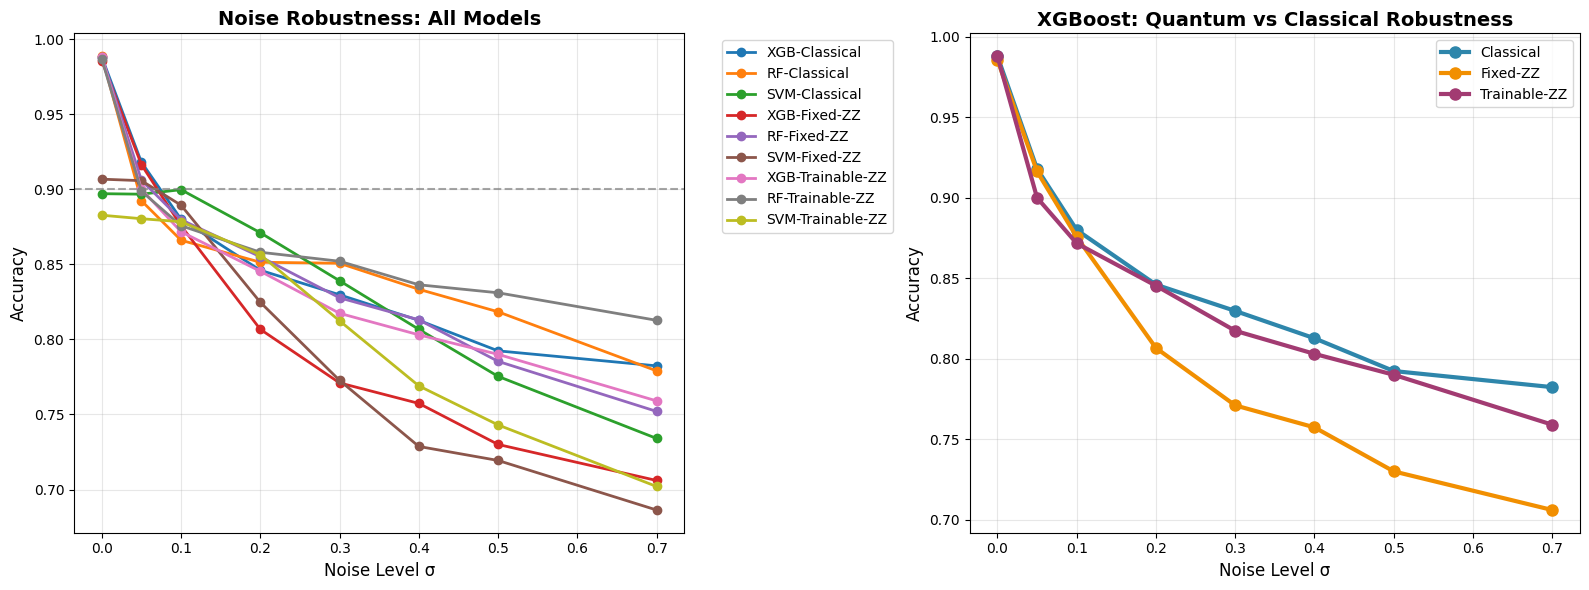


NOISE DEGRADATION SUMMARY
XGB-Classical     : 0.7823 (-20.82% from clean 0.9880)
XGB-Fixed-ZZ      : 0.7060 (-28.37% from clean 0.9857)
XGB-Trainable-ZZ  : 0.7590 (-23.18% from clean 0.9880)

📊 Robustness Ranking (least degradation = most robust):
  🏆 MOST ROBUST XGB-Fixed-ZZ: -28.37% degradation
             ⚠️ XGB-Trainable-ZZ: -23.18% degradation
             ⚠️ XGB-Classical: -20.82% degradation


In [11]:
# ============================================================
# NOISE ROBUSTNESS ANALYSIS (ENHANCED)
# ============================================================

print("\n" + "="*90)
print("🔊 NOISE ROBUSTNESS ANALYSIS")
print("="*90)

# Use Subset 1 for detailed noise analysis
subset_noise = subsets[0]
X_train_noise = subset_noise['X_train']
X_test_noise = subset_noise['X_test']
y_train_noise = subset_noise['y_train']
y_test_noise = subset_noise['y_test']

print(f"Testing on Subset 1: {len(y_test_noise)} test samples")

# Noise levels (0% to 70%)
NOISE_LEVELS = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.70]

# ========== PREPARE CLEAN FEATURES ==========
scaler_classical_noise = StandardScaler()
X_train_classical_clean = scaler_classical_noise.fit_transform(X_train_noise)
X_test_classical_clean = scaler_classical_noise.transform(X_test_noise)

scaler_quantum_noise = MinMaxScaler(feature_range=(0, 2*np.pi))
X_train_q_clean = scaler_quantum_noise.fit_transform(X_train_noise)
X_test_q_clean = scaler_quantum_noise.transform(X_test_noise)

# Extract clean quantum features
print("Extracting clean quantum features...")
Z_train_fixed_clean = extract_features(X_train_q_clean, zz_fixed_enhanced)
Z_test_fixed_clean = extract_features(X_test_q_clean, zz_fixed_enhanced)

# Optimize trainable parameters
print("Optimizing trainable circuit...")
opt_params_noise, kta_noise = optimize_circuit_adaptive(
    X_train_q_clean, y_train_noise, n_opt=150, n_epochs=20, n_trials=2
)
Z_train_trainable_clean = extract_trainable(X_train_q_clean, opt_params_noise, zz_trainable_enhanced)
Z_test_trainable_clean = extract_trainable(X_test_q_clean, opt_params_noise, zz_trainable_enhanced)

# ========== TRAIN MODELS ON CLEAN DATA ==========
scale_pos_weight_noise = np.sum(y_train_noise == 0) / max(1, np.sum(y_train_noise == 1))

models_clean = {
    'XGB-Classical': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                                   scale_pos_weight=scale_pos_weight_noise, random_state=42, n_jobs=-1),
    'RF-Classical': RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, n_jobs=-1),
    'SVM-Classical': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    
    'XGB-Fixed-ZZ': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                                  scale_pos_weight=scale_pos_weight_noise, random_state=42, n_jobs=-1),
    'RF-Fixed-ZZ': RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, n_jobs=-1),
    'SVM-Fixed-ZZ': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    
    'XGB-Trainable-ZZ': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
                                      scale_pos_weight=scale_pos_weight_noise, random_state=42, n_jobs=-1),
    'RF-Trainable-ZZ': RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, n_jobs=-1),
    'SVM-Trainable-ZZ': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
}

print("Training models on clean data...")
for name, model in models_clean.items():
    train_features = (X_train_classical_clean if 'Classical' in name 
                     else Z_train_fixed_clean if 'Fixed' in name 
                     else Z_train_trainable_clean)
    model.fit(train_features, y_train_noise)
    print(f"✅ {name} trained")

# ========== NOISE TESTING ==========
noise_results = {model: [] for model in models_clean.keys()}
noise_results['noise_level'] = []

print("\n" + "-"*80)
print("NOISE LEVELS TESTING")
print("-"*80)

for noise_std in NOISE_LEVELS:
    print(f"\nNoise σ={noise_std:.2f} ({noise_std*100:.0f}%)")
    
    # Add noise to test data
    noise = np.random.normal(0, noise_std, X_test_noise.shape)
    X_test_noisy = X_test_noise + noise * X_test_noise.std(axis=0)
    
    # Process noisy data
    X_test_classical_noisy = scaler_classical_noise.transform(X_test_noisy)
    X_test_q_noisy = scaler_quantum_noise.transform(X_test_noisy)
    
    # Extract quantum features from NOISY data
    Z_test_fixed_noisy = extract_features(X_test_q_noisy, zz_fixed_enhanced)
    Z_test_trainable_noisy = extract_trainable(X_test_q_noisy, opt_params_noise, zz_trainable_enhanced)
    
    # Test all models
    for model_name, model in models_clean.items():
        if 'Classical' in model_name:
            pred = model.predict(X_test_classical_noisy)
        elif 'Fixed' in model_name:
            pred = model.predict(Z_test_fixed_noisy)
        else:  # Trainable
            pred = model.predict(Z_test_trainable_noisy)
        
        acc = accuracy_score(y_test_noise, pred)
        noise_results[model_name].append(acc)
    
    noise_results['noise_level'].append(noise_std)
    
    # Print XGBoost results (most important)
    print(f"  XGBoost: Classical={noise_results['XGB-Classical'][-1]:.4f}, "
          f"FixedZZ={noise_results['XGB-Fixed-ZZ'][-1]:.4f}, "
          f"Trainable={noise_results['XGB-Trainable-ZZ'][-1]:.4f}")

# ========== NOISE ANALYSIS PLOT ==========
df_noise = pd.DataFrame(noise_results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All models
for model in df_noise.columns:
    if model != 'noise_level':
        ax1.plot(df_noise['noise_level'], df_noise[model], 'o-', label=model, linewidth=2)
ax1.set_xlabel('Noise Level σ', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Noise Robustness: All Models', fontsize=14, weight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.axhline(0.90, color='gray', linestyle='--', alpha=0.7, label='90% Threshold')

# Plot 2: XGBoost only (cleanest)
models_xgb = ['XGB-Classical', 'XGB-Fixed-ZZ', 'XGB-Trainable-ZZ']
colors = ['#2E86AB', '#F18F01', '#A23B72']
for i, model in enumerate(models_xgb):
    ax2.plot(df_noise['noise_level'], df_noise[model], 'o-', 
             label=model.replace('XGB-', ''), linewidth=3, markersize=8, color=colors[i])

# Fill quantum advantage regions
for i in range(1, len(NOISE_LEVELS)):
    if (df_noise['XGB-Trainable-ZZ'][i] > df_noise['XGB-Classical'][i] and
        df_noise['XGB-Fixed-ZZ'][i] > df_noise['XGB-Classical'][i]):
        ax2.fill_between([df_noise['noise_level'][i-1], df_noise['noise_level'][i]], 
                        df_noise['XGB-Classical'], df_noise['XGB-Trainable-ZZ'], 
                        alpha=0.2, color='green', label='Quantum Advantage')

ax2.set_xlabel('Noise Level σ', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('XGBoost: Quantum vs Classical Robustness', fontsize=14, weight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cicids_noise_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== NOISE DEGRADATION ANALYSIS ==========
print("\n" + "="*60)
print("NOISE DEGRADATION SUMMARY")
print("="*60)

degradation = {}
for model in ['XGB-Classical', 'XGB-Fixed-ZZ', 'XGB-Trainable-ZZ']:
    clean_acc = noise_results[model][0]
    noisy_acc = noise_results[model][-1]
    drop_pct = ((noisy_acc - clean_acc) / clean_acc) * 100
    degradation[model] = drop_pct
    print(f"{model:18}: {noisy_acc:.4f} ({drop_pct:+.2f}% from clean {clean_acc:.4f})")

print("\n📊 Robustness Ranking (least degradation = most robust):")
sorted_robust = sorted(degradation.items(), key=lambda x: x[1])
for rank, (model, drop) in enumerate(sorted_robust, 1):
    status = "🏆 MOST ROBUST" if rank == 1 else "✅" if drop > -10 else "⚠️"
    print(f"{status:>15} {model}: {drop:+.2f}% degradation")


